## Importing the needed libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import datetime

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 999

## Importing the *orders* data set

In [2]:
orders_path = '../orders_merged.csv'

Dob - date of birth;

PoR - customer place of residence;

EDT - expected delivery time;

ADT - actual delivery time; 

RoR - reason of return

In [3]:
df_orders = pd.read_csv(orders_path,
                        #parse_dates=['DoB', 'Order date'], //Way too slow
                        dtype=
                        {'Customer number': np.int64,
                         'Gender': object,
                         'PoR': object,
                         'Order number': np.int64,
                         'Product number': object,
                         'Sub category': object,
                         'Category': object,
                         'Count': np.int16,
                         'Price': np.float64,
                         'EDT': np.int16,
                         'ADT': np.int16,
                         'RoR': object,
                         'Rating': np.int8,
                         'Returned': np.float64,
                         'Price per Product': np.float64,
                         'Man': np.float64,
                         'Woman': np.float64,
                         'Age': np.int64,
                         'Order month': np.int64,
                         'Order year': np.int64,
                         'DeltaT': np.int64})

# Forecasting demand
Predict the demand of the category garden furniture for 2019.  
This can also be done for one specific product. This is useful for purchasing.

In [4]:
df_furniture = df_orders.copy().loc[df_orders['Category']=='Garden furniture']

In [5]:
df_furniture.head(10)

,Customer number,DoB,Gender,PoR,Order number,Order date,Product number,Sub category,Category,Count,Price,EDT,ADT,RoR,Rating
0,1063418,15-01-1944,Woman,Bloemendaal,1251137,20-12-2014,5146308036084,Garden chairs,Garden furniture,1,1090.82,2,2,NaN,-1
5,1016474,16-01-1937,Man,Hollands Kroon,294578,19-08-2014,8188604007365,Garden chairs,Garden furniture,1,940.43,4,4,NaN,-1
8,1018918,07-01-1974,Woman,Coevorden,1202222,19-09-2014,3193523049599,Garden sets,Garden furniture,1,1079.03,3,-1,No reason given,4
13,1018918,07-01-1974,Woman,Coevorden,1202222,19-09-2014,3188775004229,Garden chairs,Garden furniture,1,340.07,3,3,NaN,4
19,1018918,07-01-1974,Woman,Coevorden,1202222,19-09-2014,4169424015147,Garden benches,Garden furniture,1,1189.15,1,3,NaN,4
26,1032738,06-01-1980,Man,Waterland,997869,20-07-2013,8177666043794,Garden chairs,Garden furniture,1,906.65,1,20,NaN,-1
27,1029598,08-01-1970,Man,Oss,1606587,12-07-2016,4146448030684,Garden chairs,Garden furniture,1,248.06,1,1,NaN,-1
38,1018702,03-01-1990,Man,Terschelling,1433754,31-12-2015,5100706141917,Sun beds,Garden furniture,4,267.28,3,3,NaN,-1
43,1060208,17-01-1934,Man,Korendijk,255450,06-02-2014,1130770100774,Sun beds,Garden furniture,6,437.22,2,2,NaN,-1
53,1068164,09-01-1965,Man,Alphen aan den Rijn,417413,20-04-2015,2142622044388,Garden sets,Garden furniture,1,944.79,2,2,NaN,-1


## Sort all the orders by order date. Group by the date and sum the quantity.

In [6]:
df_furniture['Order date'] = pd.to_datetime(df_furniture["Order date"], format="%d-%m-%Y")
df_furniture = df_furniture.sort_values('Order date')
df_furniture = df_furniture.groupby('Order date')['Count'].sum().reset_index()

df_temp = df_furniture
df_furniture = pd.DataFrame()
df_furniture['Order date'] = pd.date_range(df_temp['Order date'].values[0], '09/30/2018')
df_furniture['Count'] = np.nan
df_furniture = df_furniture.set_index('Order date')
df_temp = df_temp.set_index('Order date')
df_furniture['Count'] = df_temp['Count']
#df_furniture['Count'].interpolate(inplace=True)
df_furniture['Count'].fillna(0, inplace=True)
#df_furniture = df_furniture[:'11/30/2018']
df_furniture.head(10)

,Count
Order date,
2013-01-01,1844
2013-01-02,1350
2013-01-03,1878
2013-01-04,980
2013-01-05,966
2013-01-06,324
2013-01-07,1744
2013-01-08,1632
2013-01-09,465


## Apply ARIMA model to predict sales
The used prediction model is ARIMA. This is because it is a model for forecasting and predicting timeseries.  
This is perfect for our usecase.

In [7]:
from statsmodels.tsa.arima_model import ARIMA

In [8]:
model = ARIMA(df_furniture['Count'], order=(1,0,0), freq="D")
results = model.fit(disp=0)

In [9]:
forecast = results.predict(start = '01/01/2013', end = '12/31/2019')

Generate a graph with the actual and the predicted data

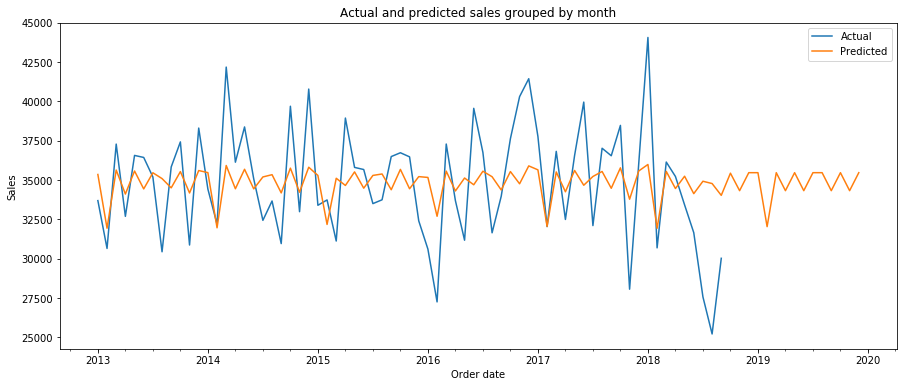

In [24]:
resampled = df_furniture['Count'].resample('MS').sum()
resampled.plot(figsize=(15, 6), label="Actual")
resampled_forecast = forecast.resample('MS').sum()
resampled_forecast.plot(figsize=(15, 6), label="Predicted")
plt.ylabel('Sales')
plt.title('Actual and predicted sales grouped by month')
plt.legend()
plt.show()

### Calculate the mean squared error
This gives a error rate that we can use to compare it to our other models. The error needs to be as low as possible.

In [21]:
from sklearn import metrics
mae = metrics.mean_absolute_error(df_furniture['Count'][1:].resample('MS').sum(), forecast[1:len(df_furniture['Count'])].resample('MS').sum())
print('MAE: %.3f' % mae)
mse = metrics.mean_squared_error(df_furniture['Count'][1:].resample('MS').sum(), forecast[1:len(df_furniture['Count'])].resample('MS').sum())
print('MSE: %.3f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %.3f' % rmse)
nrmse = rmse / (df_furniture['Count'][1:].resample('MS').sum().max()-df_furniture['Count'][1:].resample('MS').sum().min())
print('NRMSE: %.3f' % nrmse)

MAE: 2627.249
MSE: 10835091.288
RMSE: 3291.670
NRMSE: 0.175


### Plot residual errors
These plots give a better insight in the differences between the actual sales and the predictions

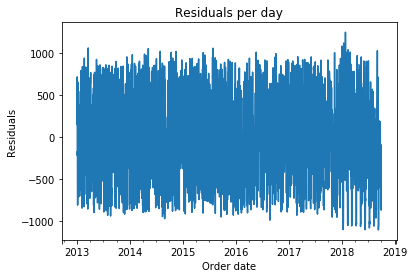

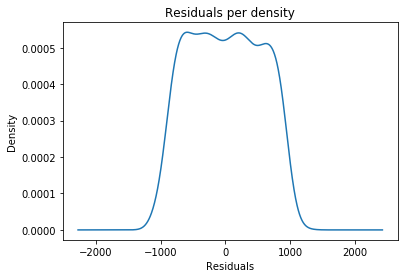

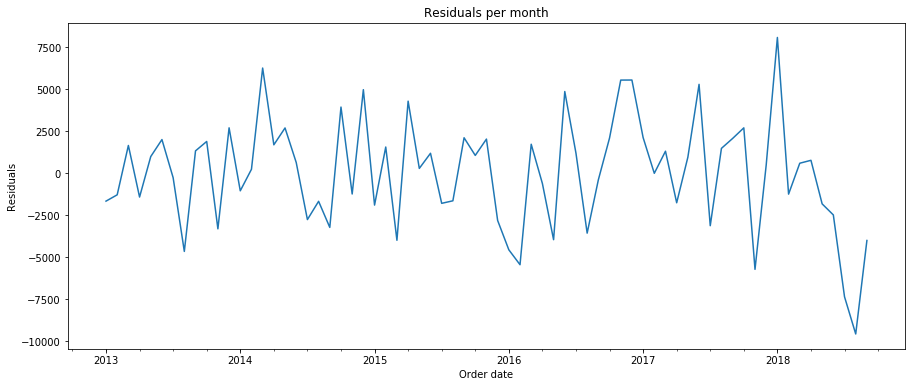

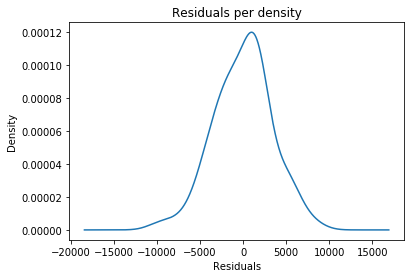

                 0
count  2099.000000
mean     -0.002754
std     550.997702
min   -1102.706552
25%    -468.829910
50%      -1.765757
75%     465.521329
max    1250.958678


In [25]:
residuals = pd.DataFrame(results.resid)
residuals.plot()
plt.ylabel('Residuals')
plt.legend().remove()
plt.title("Residuals per day")
plt.show()
residuals.plot(kind='kde', label="Residuals")
plt.xlabel('Residuals')
plt.legend().remove()
plt.title("Residuals per density")
plt.show()
month = residuals.resample('MS').sum()
month.plot(figsize=(15, 6))
plt.ylabel('Residuals')
plt.legend().remove()
plt.title("Residuals per month")
plt.show()
month.plot(kind='kde', label="Residuals")
plt.xlabel('Residuals')
plt.legend().remove()
plt.title("Residuals per density")
plt.show()
print(residuals.describe())

## Conclusion
Figure 1 shows that there are no patterns in the sales. This makes it very hard to create an accurate model.
The results show that the predictions are around the mean.
In figures 2 and 3 it is shown that the error rate is mostly within 1000 sales. This is not very good.

If there were some patterns in the sales numbers the predictions would be more accurate.